## Setup

In [ ]:
!git clone https://github.com/cyyeh/auto-sketch.git

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

from sketchrnn import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

tf: 2.0.0
tf.keras: 2.2.4-tf


## Load The Data

In [2]:
data_class = 'rabbit'

utils.download_dataset('rabbit', '../data')

Downloaded: ../data/rabbit.npz


In [3]:
data = np.load('../data/{}.npz'.format(data_class),encoding='latin1',allow_pickle=True)

data_train = [dataset.cleanup(d) for d in data['train']]
data_valid = [dataset.cleanup(d) for d in data['valid']]
data_test = [dataset.cleanup(d) for d in data['test']]

max_seq_len = max(map(len, np.concatenate([data_train, data_valid, data_test])))
scale_factor = dataset.calc_scale_factor(data_train)

To look at some random samples from the raw test set

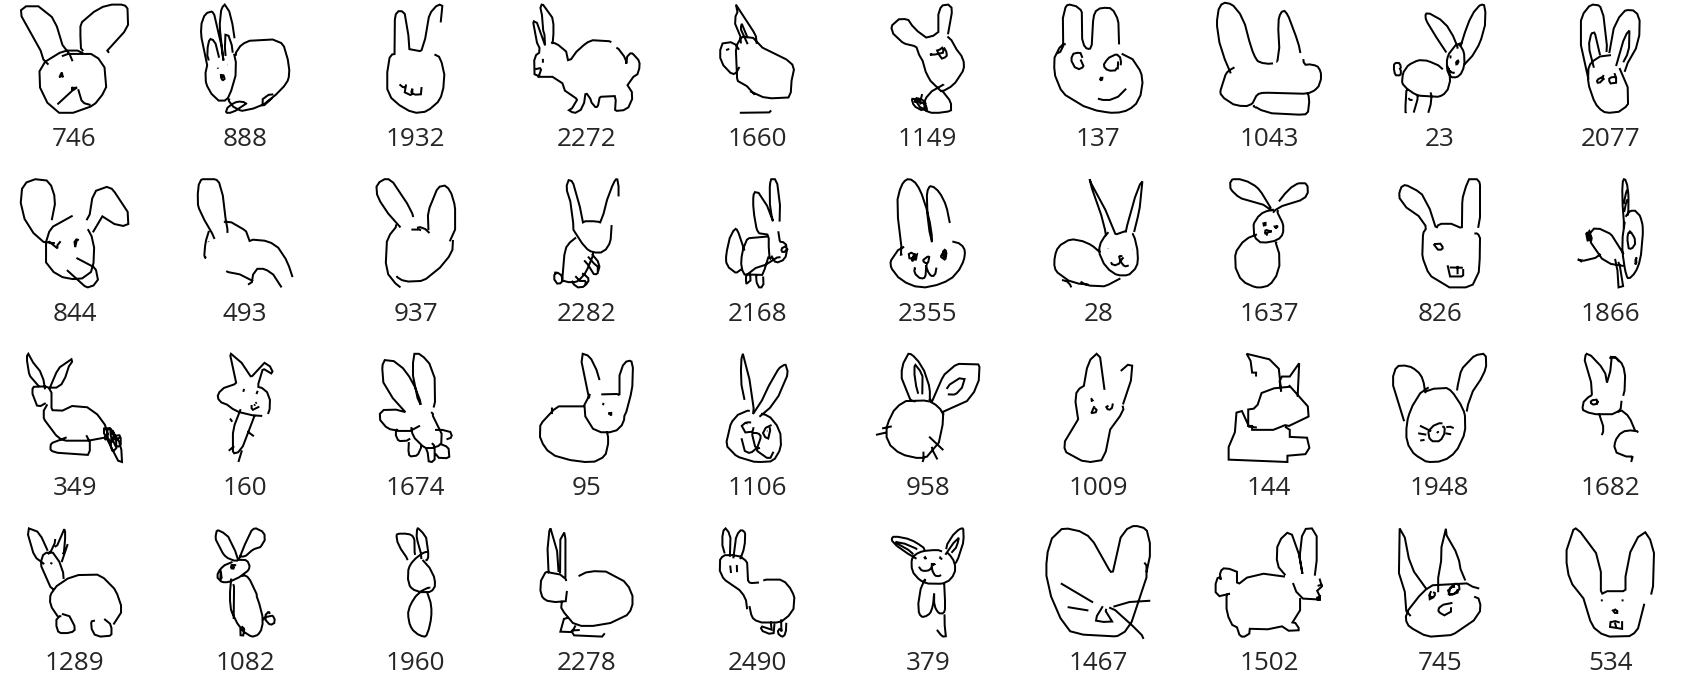

In [4]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

perm = np.random.permutation(range(len(data_test)))[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], data_train[idx])
    ax[x][y].set(xlabel=idx)
    
utils.plt_show()

Some cleanup for later use

In [5]:
ds_test = np.array([dataset.pad(dataset.normalize(d, scale_factor), max_seq_len) for d in data_test])

In [6]:
n_points = np.argmax(ds_test[:,:,4]==1,-1)
n_strokes = ds_test[:,:,3].sum(1)

pmin, pmax = np.percentile(n_points,[1,99])
smin, smax = np.percentile(n_strokes,[1,99])

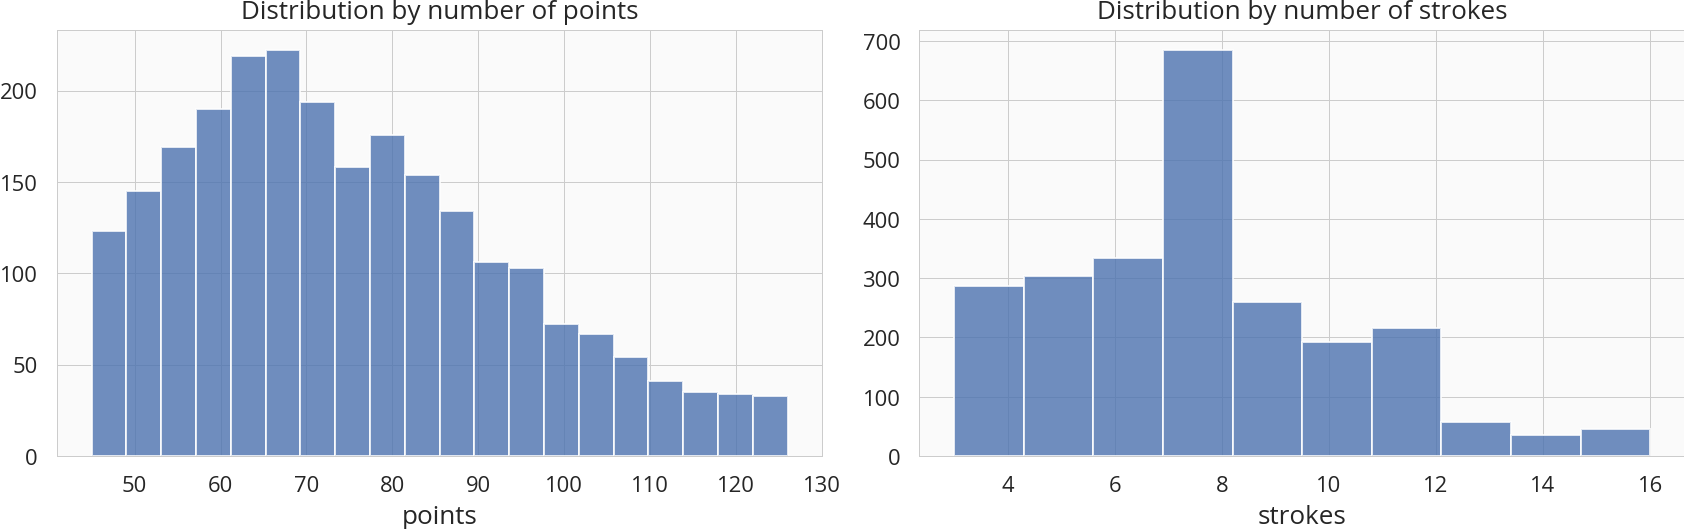

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(n_points[(pmin < n_points) & (n_points < pmax)], 20, alpha=0.8)
ax[0].set(xlabel="points", 
          title="Distribution by number of points")

ax[1].hist(n_strokes[(smin < n_strokes) & (n_strokes < smax)], 10, alpha=0.8)
ax[1].set(xlabel="strokes", 
          title="Distribution by number of strokes")

utils.plt_show()

In [8]:
## Filter invalid samples
ds_test = ds_test[n_points > 0]
n_strokes = n_strokes[n_points > 0]
n_points = n_points[n_points > 0]

## Load The Models

In [9]:
hps = {
    "max_seq_len": max_seq_len,
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 1,
    "recurrent_dropout_prob": 0.1,
    "enc_rnn_size": 256,
    "dec_rnn_size": 512,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
}

In [10]:
sketchrnn = models.SketchRNN(hps)
sketchrnn.models['full'].summary()

initial_epoch, initial_loss = 100, 0.06
checkpoint = os.path.join('../models/', 'sketch_rnn_{}_weights.{:02d}_{:.2f}.hdf5').format(data_class, initial_epoch, initial_loss)
sketchrnn.load_weights(checkpoint)

Model: "sketchrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 131, 5)]     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 128), (None, 667904      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
initial_state (Model)           [(None, 512), (None, 132096      encoder[1][0]                    
__________________________________________________________________________________________

## Sampling

Let's take a look at a random sample from the latent space

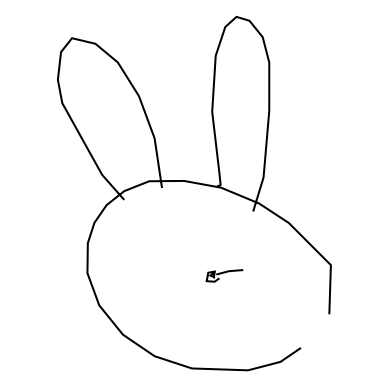

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))

strokes = sketchrnn.sample(temperature=0.1)
utils.plot_strokes(ax, utils.to_normal_strokes(strokes))

utils.plt_show()

Some more random samples from the latent space

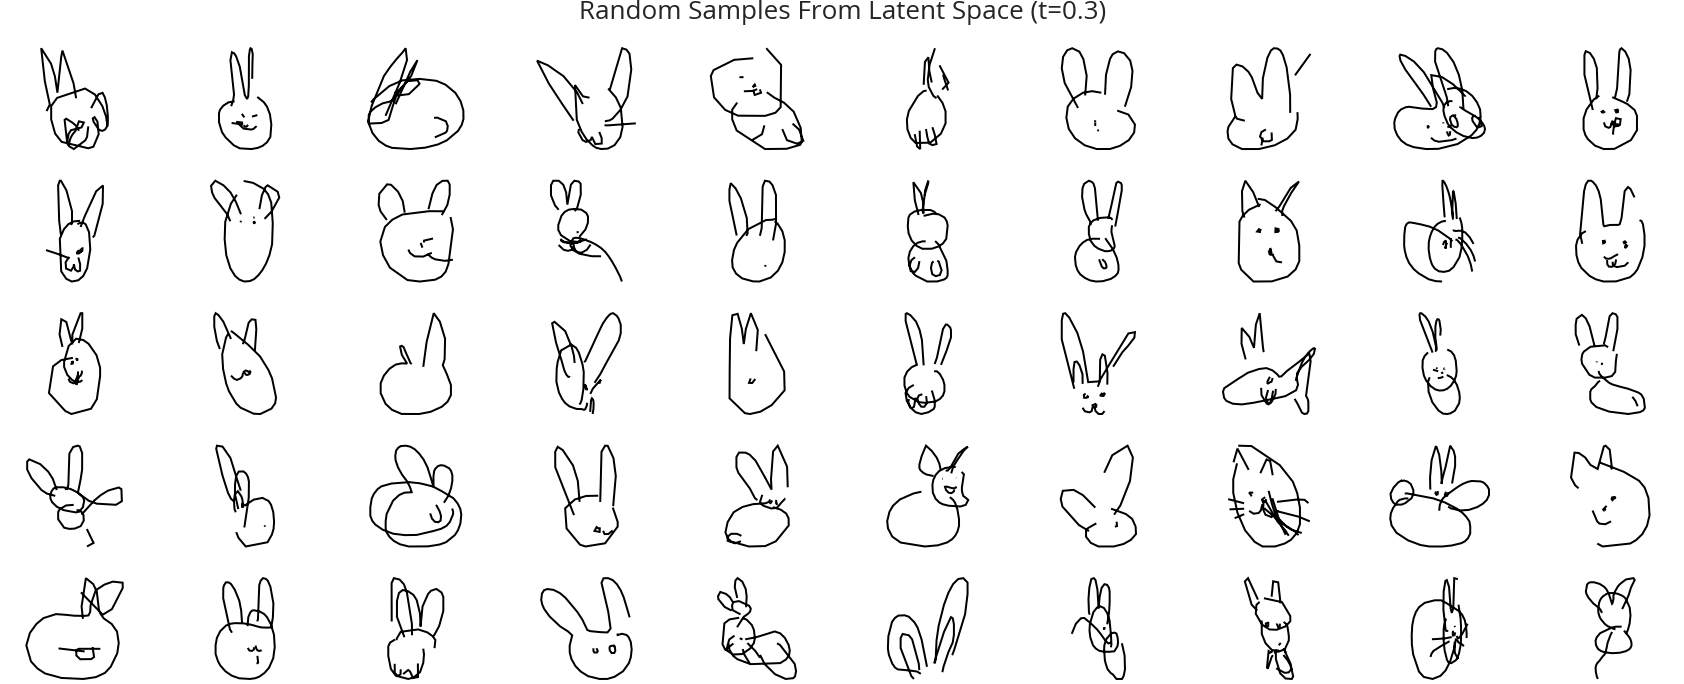

In [29]:
n = [5, 10]
temp = 0.3

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

for i in trange(n[0] * n[1]):
    strokes = sketchrnn.sample(temperature=temp)
    utils.plot_strokes(ax[i // n[1]][i % n[1]], utils.to_normal_strokes(strokes))
    
fig.suptitle("Random Samples From Latent Space (t={})".format(temp))

utils.plt_show(rect=[0, 0, 1, 0.95])

and at various temperatures

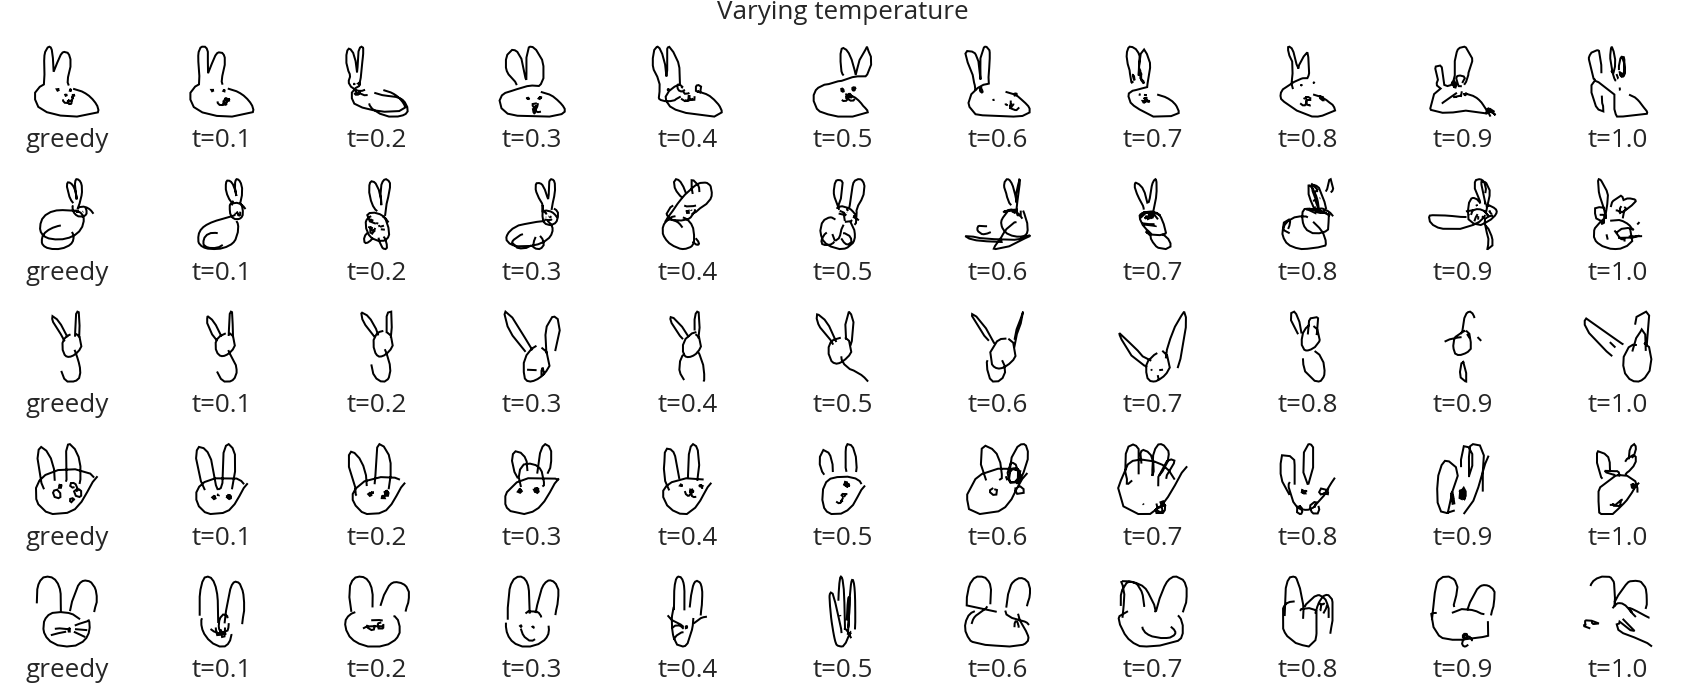

In [24]:
fig = plt.figure(figsize=(12, 5))

n = [5,11]

with tqdm(total=n[0]*n[1]) as pbar:
    for i in range(n[0]):
        z = np.random.randn(1, hps['z_size']).astype(np.float32)

        for j in range(n[1]):
            ax = plt.subplot(n[0], n[1], i * n[1] + j + 1)
            if j == 0:
                strokes = sketchrnn.sample(z=z,greedy=True)
            else:
                strokes = sketchrnn.sample(z=z,temperature=j*0.1)
            utils.plot_strokes(ax, utils.to_normal_strokes(strokes))
            ax.set(xlabel='greedy' if j == 0 else 't={:.1f}'.format(j*0.1))

            pbar.update(1)
            
fig.suptitle("Varying temperature")

utils.plt_show(rect=[0, 0, 1, 0.95])

Next we can see how the model decode / encode samples with different temperatures

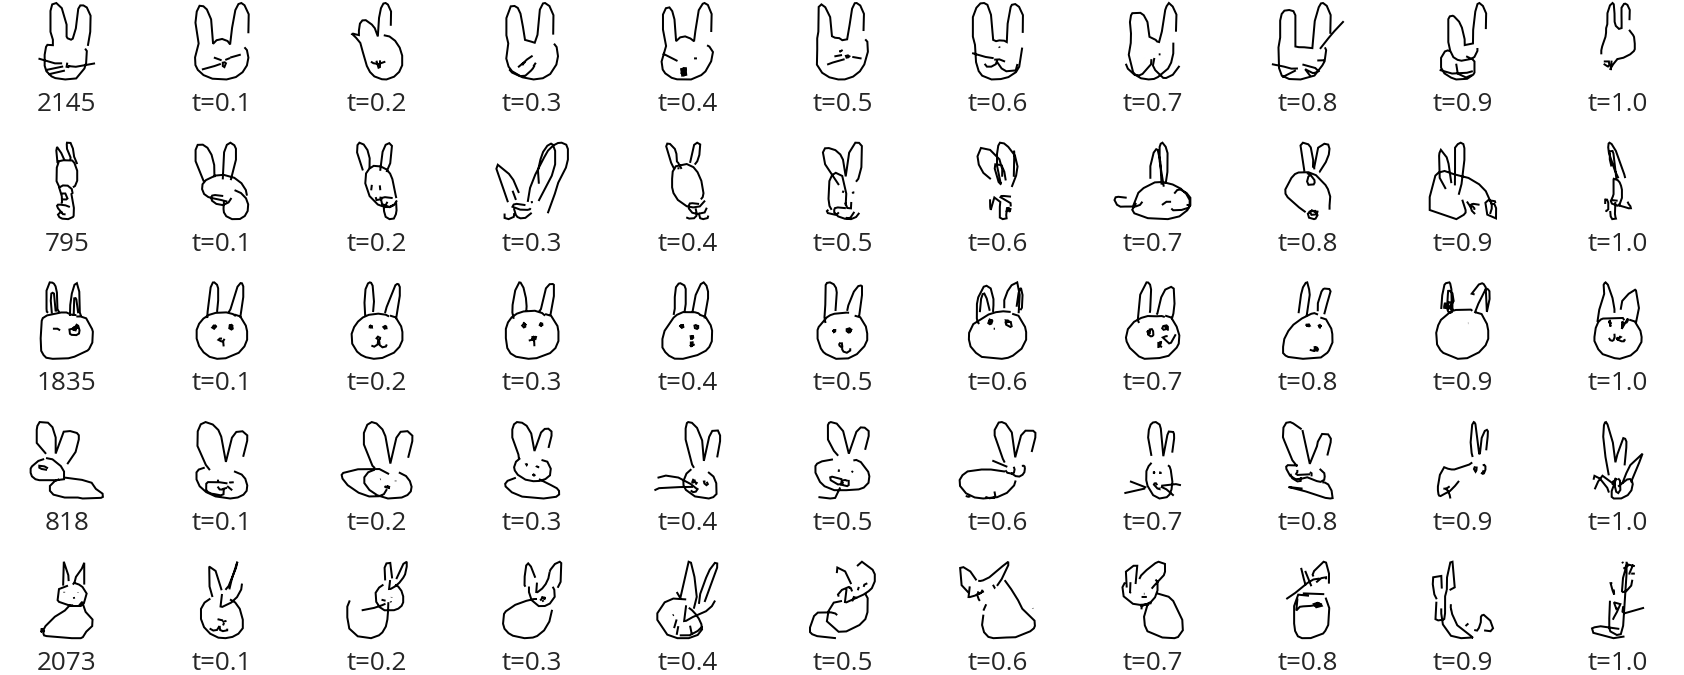

In [14]:
fig = plt.figure(figsize=(12, 5))

n = 5

indices = np.random.permutation(range(len(ds_test)))[:n]

with tqdm(total=n*11) as pbar:
    for i in range(n):
        idx = indices[i]

        d = np.expand_dims(ds_test[idx],0)
        z = sketchrnn.models['encoder'].predict(d[:,1:])[0]

        ax = plt.subplot(n, 11, i * 11 + 1)
        utils.plot_strokes(ax, utils.to_normal_strokes(d[0]))
        ax.set(xlabel=idx)

        pbar.update(1)

        for j in range(1,11):
            strokes = sketchrnn.sample(z=z, temperature=j*0.1)

            ax = plt.subplot(n, 11, i * 11 + j + 1)
            utils.plot_strokes(ax, utils.to_normal_strokes(strokes))
            ax.set(xlabel='t={:.1f}'.format(j*0.1))

            pbar.update(1)

utils.plt_show()

Now let's try to interpolation between samples

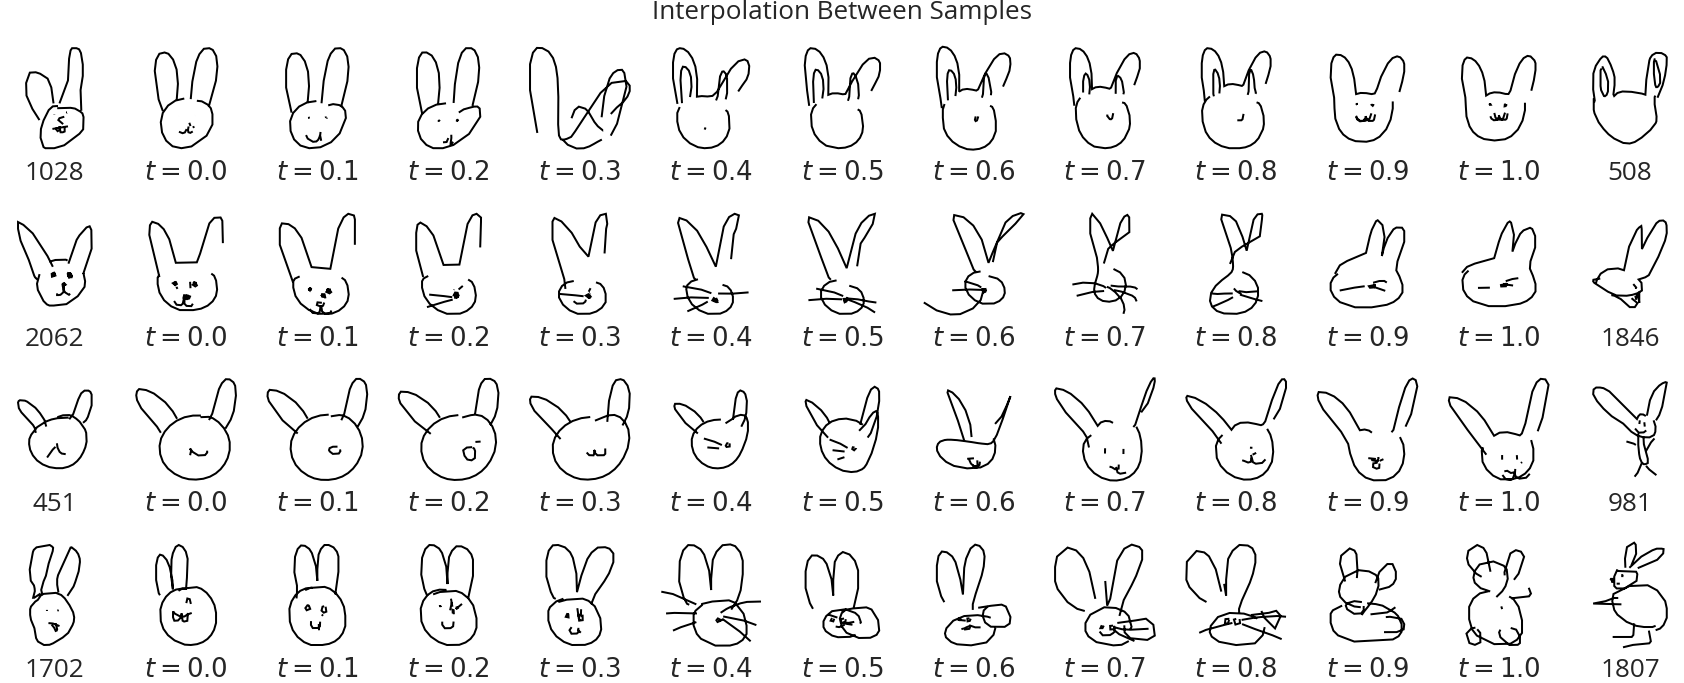

In [16]:
n = 4

indices = np.random.permutation(range(len(ds_test)))[:n * 2]

fig, ax = plt.subplots(n, 13, figsize=(12, 5))

with tqdm(total=n*11) as pbar:
    for i in range(n):
        idx1, idx2 = indices[i*2:i*2+2]

        d1, d2 = ds_test[idx1], ds_test[idx2]
        z1 = sketchrnn.models['encoder'].predict(d1[np.newaxis,1:])[0].squeeze()
        z2 = sketchrnn.models['encoder'].predict(d2[np.newaxis,1:])[0].squeeze()

        utils.plot_strokes(ax[i][0], utils.to_normal_strokes(d1))
        ax[i][0].set(xlabel=idx1)

        for j in range(11):
            z = np.expand_dims(utils.slerp(z1,z2,j*0.1),0)
            strokes = sketchrnn.sample(z=z, greedy=True)
            utils.plot_strokes(ax[i][j+1], utils.to_normal_strokes(strokes))
            ax[i][j+1].set(xlabel='$t={:.1f}$'.format(j*0.1))
            
            pbar.update(1)

        utils.plot_strokes(ax[i][-1], utils.to_normal_strokes(d2))
        ax[i][-1].set(xlabel=idx2)
        
fig.suptitle("Interpolation Between Samples")

utils.plt_show(rect=[0, 0, 1, 0.95])

## Perplexities

We can calculate perplexity using the method from [here](http://colinmorris.github.io/blog/bad_flamingos).

In [11]:
batch_size = 100
n = len(ds_test)

ppxs = np.zeros(n)

for i in trange(n // batch_size + 1):
    batch = ds_test[i*batch_size:(i+1)*batch_size]
    seq_lens = np.argmax(batch[:,:,4]==1,-1)
    
    enc_in, dec_in = batch[:,1:], batch[:,:-1]
    outputs = sketchrnn.models['full']([enc_in, dec_in])[0]
    loss = models.calculate_md_loss(enc_in, outputs)
    
    ppxs[i*batch_size:(i+1)*batch_size] = tf.math.reduce_sum(tf.squeeze(loss),-1) / seq_lens

In [17]:
norm = mpl.colors.Normalize(vmin=ppxs.min(), vmax=ppxs.max())
cmap = mpl.cm.get_cmap('RdYlBu')

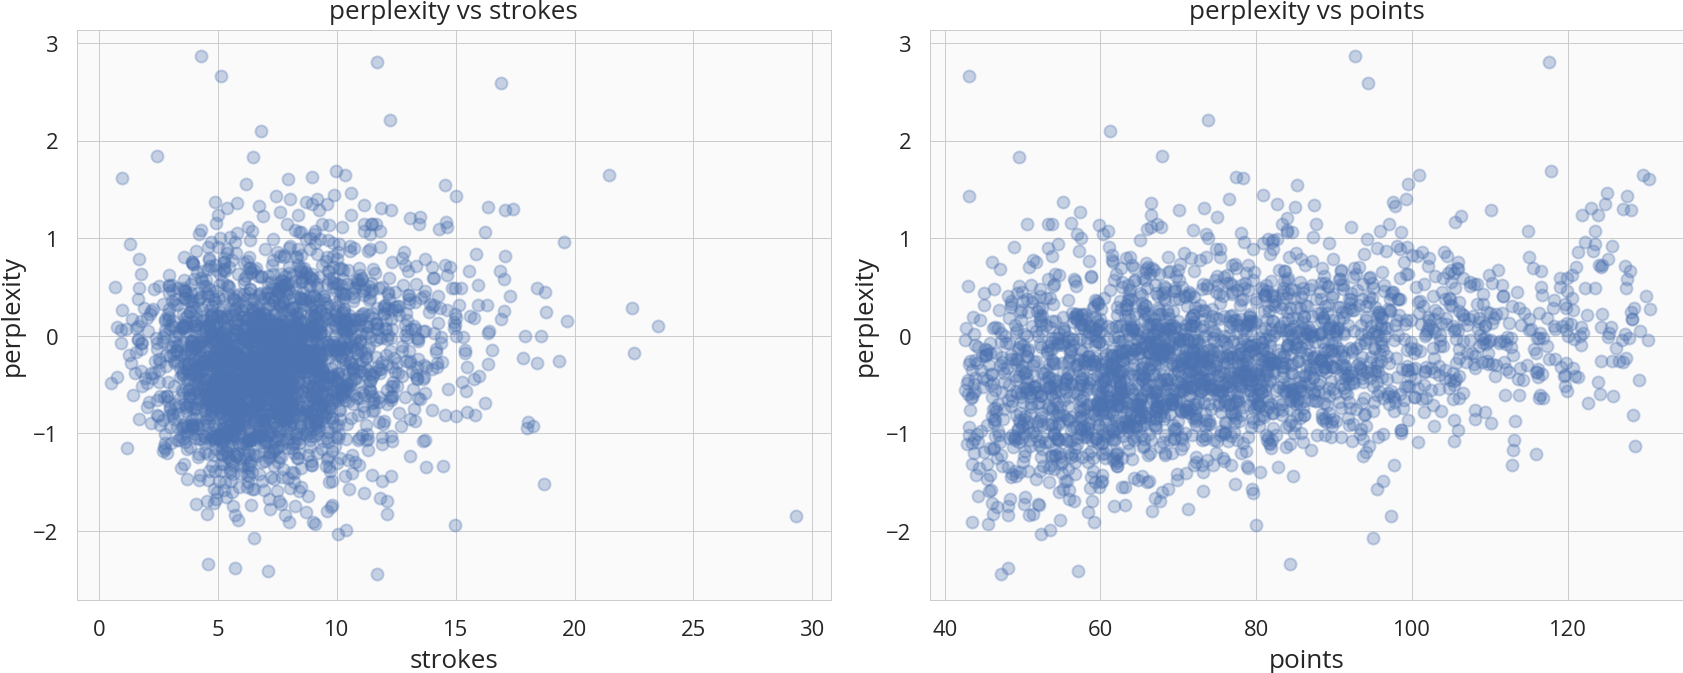

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(n_strokes - (np.random.rand(len(n_strokes)) - .5), ppxs, 'bo',alpha=0.3)
ax[0].set(xlabel="strokes", ylabel="perplexity",
          title="perplexity vs strokes")

ax[1].plot(n_points - (np.random.rand(len(n_points)) - .5), ppxs, 'bo',alpha=0.3)
ax[1].set(xlabel="points", ylabel="perplexity",
          title="perplexity vs points")

utils.plt_show()

Here are the best samples with best scores

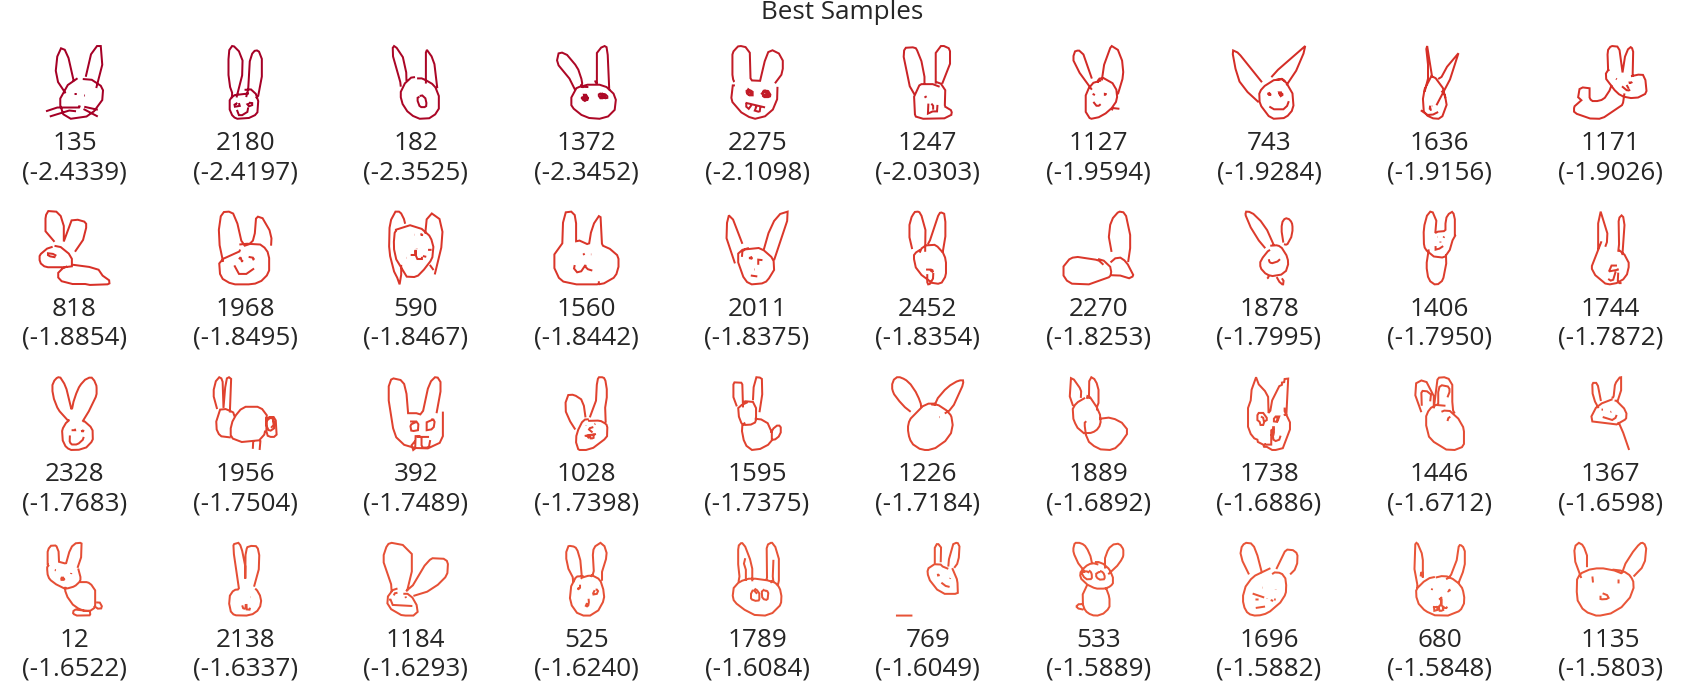

In [30]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

perm = np.argsort(ppxs)[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], utils.to_normal_strokes(ds_test[idx]), ec=cmap(norm(ppxs[idx])))
    ax[x][y].set(xlabel='{}\n({:.4f})'.format(idx, ppxs[idx]))
    
fig.suptitle("Best Samples")
    
utils.plt_show(rect=[0, 0, 1, 0.95])

and the worst ones...

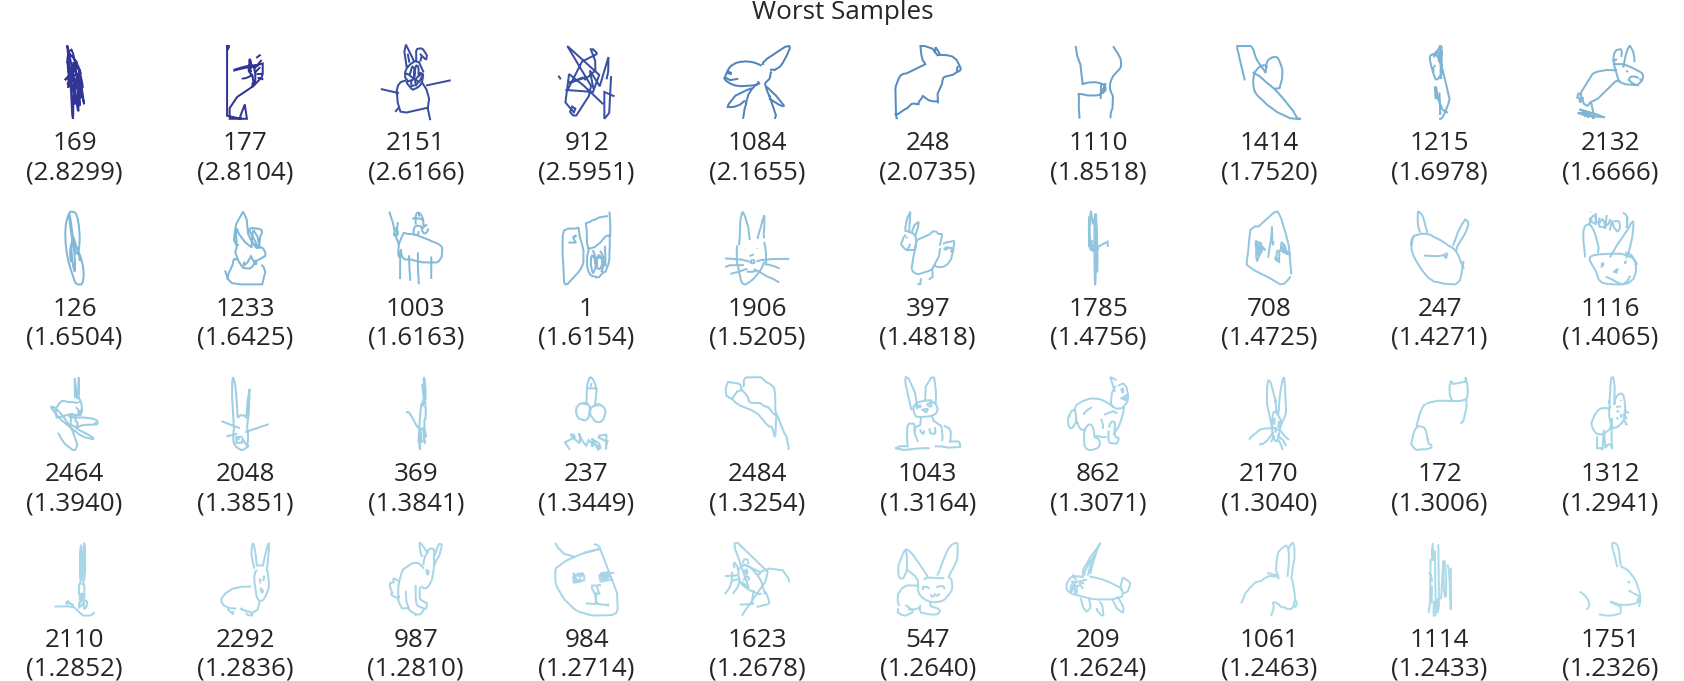

In [31]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(12, 5))

perm = np.argsort(ppxs)[-n[0]*n[1]:][::-1]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], utils.to_normal_strokes(ds_test[idx]), ec=cmap(norm(ppxs[idx])))
    ax[x][y].set(xlabel='{}\n({:.4f})'.format(idx,ppxs[idx]))
    
fig.suptitle("Worst Samples")
    
utils.plt_show(rect=[0, 0, 1, 0.95])

### Layout with PCA

We can also use TSNE, but since essentially the latent space is gaussian, PCA should be enough here.

In [19]:
Z = sketchrnn.models['encoder'].predict(ds_test[:,1:])[0]

In [20]:
pca = PCA(n_components=2, svd_solver='randomized', whiten=True).fit(Z)
print("Explained variances ratio: {}".format(pca.explained_variance_ratio_))
print("Explained variances: {}".format(pca.explained_variance_))

Z_pca = pca.transform(Z)

Explained variances ratio: [0.01263226 0.01210496]
Explained variances: [1.5588282 1.4937588]


In [21]:
((pc1_min, pc2_min), (pc1_max, pc2_max)) = np.percentile(Z_pca, q=[1, 99], axis=0)

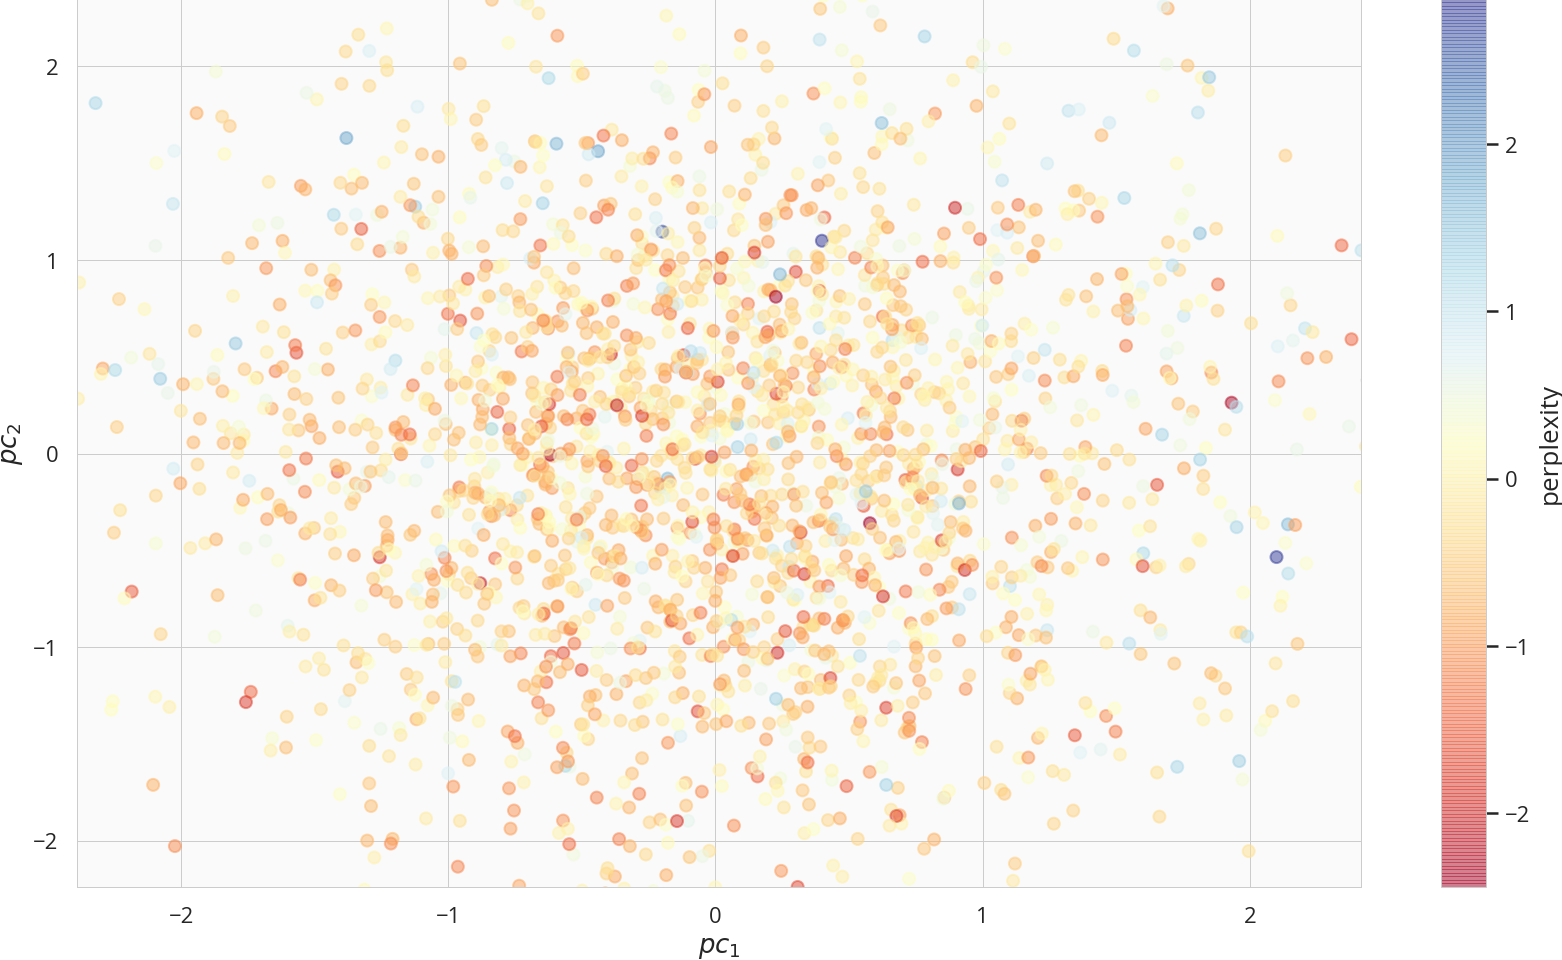

In [22]:
fig, ax = plt.subplots(figsize=(12,7))

sc = ax.scatter(*Z_pca.T, c=ppxs, alpha=0.5,cmap=cmap)
ax.set(xlabel='$pc_1$',ylabel='$pc_2$',
       xlim=(pc1_min,pc1_max),ylim=(pc2_min,pc2_max))

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('perplexity')

utils.plt_show()

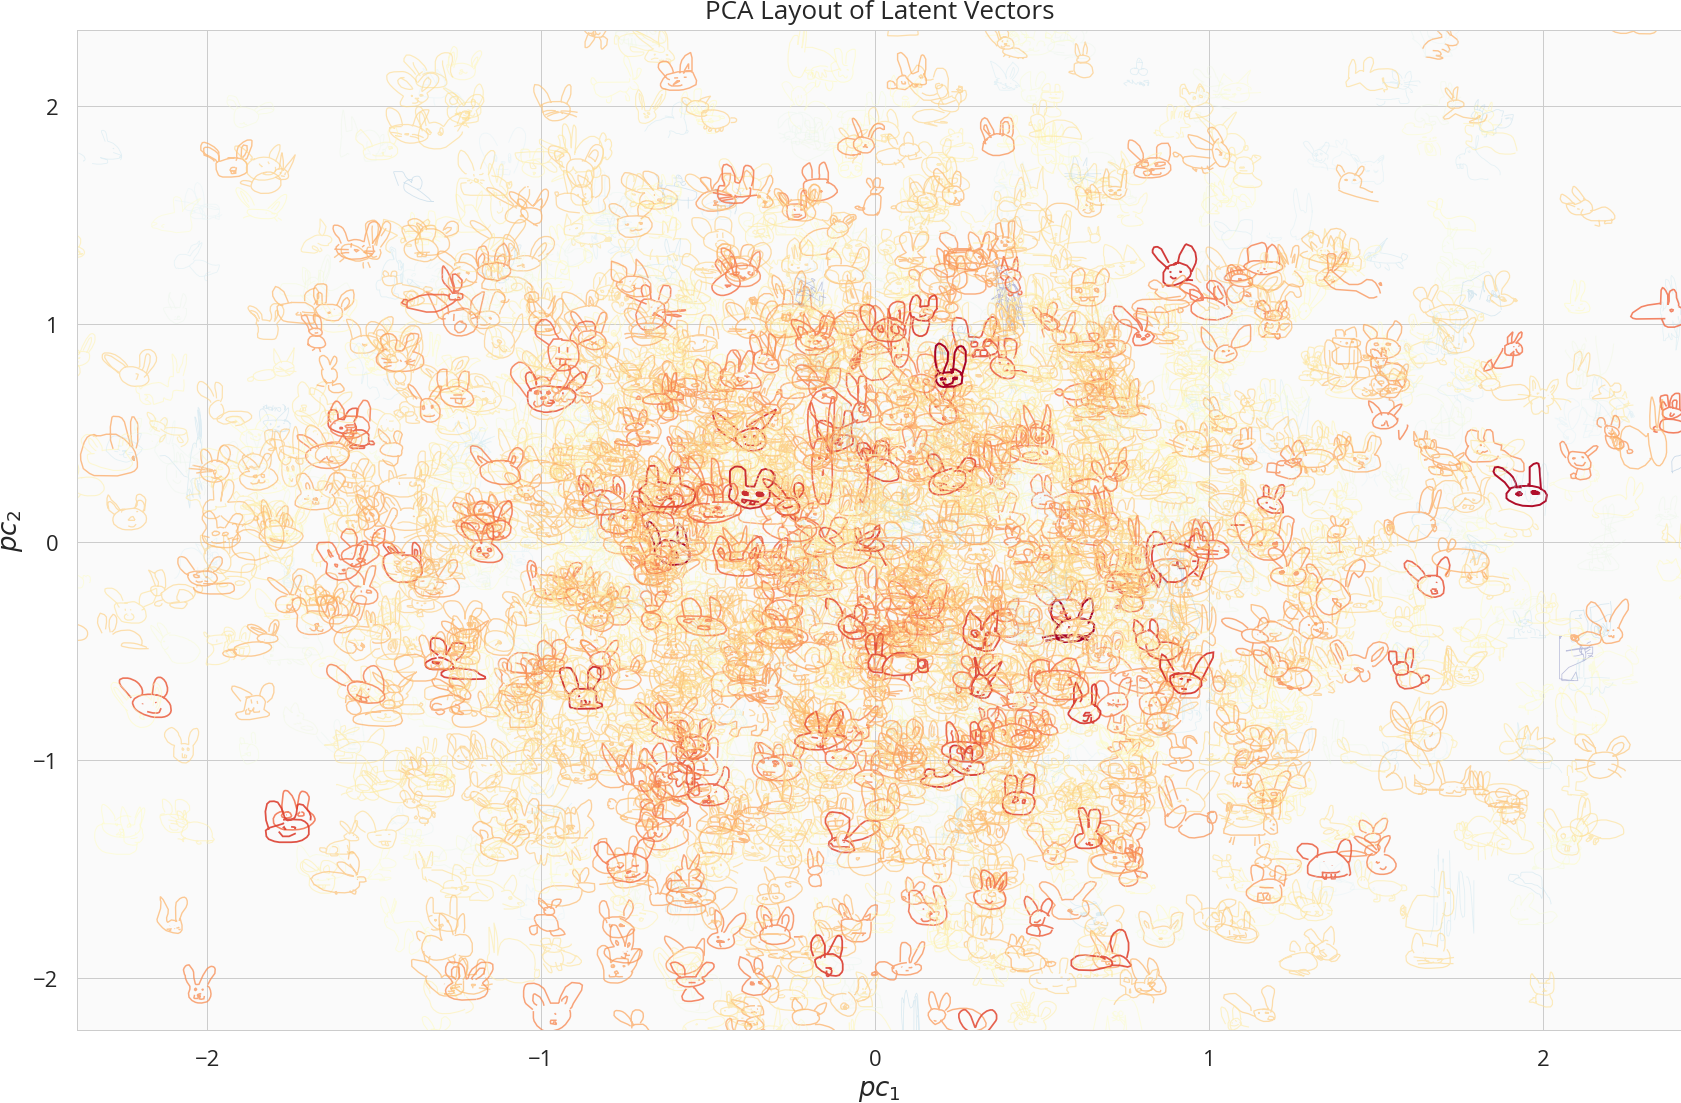

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

for i, strokes in enumerate(ds_test):
    t = norm(ppxs[i])
    path = utils.make_mpl_path(utils.to_normal_strokes(strokes))
    path.vertices *= 0.05 + (1-t) * 0.05
    path.vertices += Z_pca[i]
    ax.add_patch(PathPatch(path, lw=max(1-t,0.4), fc='none',
                           ec=cmap(t), alpha=max(1-t,0.3)))
    
ax.set(xlim=(pc1_min,pc1_max),ylim=(pc2_min,pc2_max),
       xlabel='$pc_1$',ylabel='$pc_2$',
       title="PCA Layout of Latent Vectors")

utils.plt_show()

## Animation

Let's pick some of the best samples and interpolate between them.

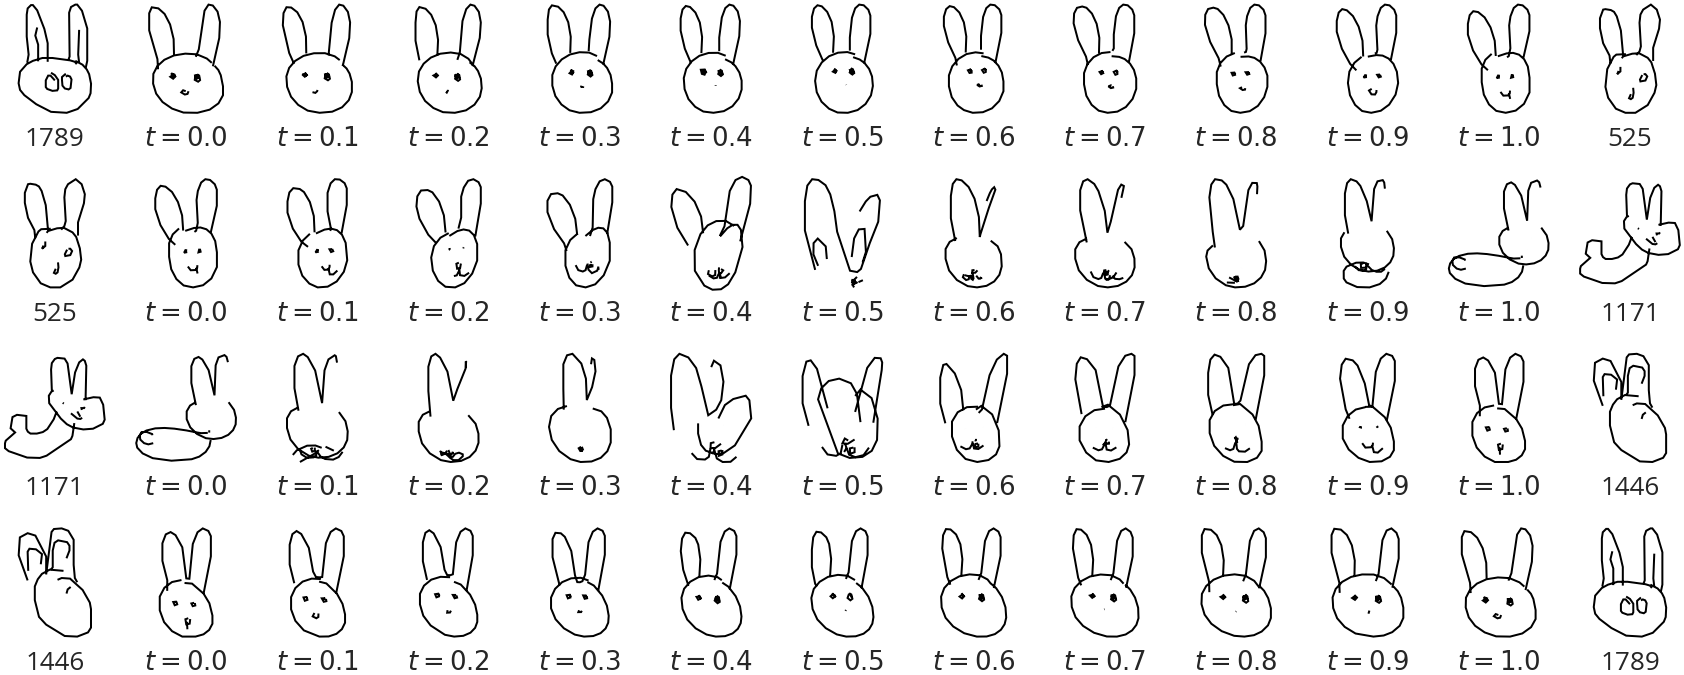

In [36]:
n = 4
indices = shuffle(np.argsort(ppxs)[:50])[:n]

ds = ds_test[indices]
zs = sketchrnn.models['encoder'].predict(ds[:,1:])[0]

fig, ax = plt.subplots(n, 13, figsize=(12, 5))

with tqdm(total=n * 11) as pbar:
    it = range(n)
    for s, t in zip(it, np.roll(it,-1)):
        d1, d2 = ds[s], ds[t]
        z1, z2 = zs[s], zs[t]

        utils.plot_strokes(ax[s][0], utils.to_normal_strokes(d1))
        ax[s][0].set(xlabel=indices[s])
        
        for j in range(11):
            z = np.expand_dims(utils.slerp(z1,z2,j*0.1),0)
            strokes = sketchrnn.sample(z=z, greedy=True)
            utils.plot_strokes(ax[s][j+1], utils.to_normal_strokes(strokes))
            ax[s][j+1].set(xlabel='$t={:.1f}$'.format(j*0.1))
            pbar.update(1)

        utils.plot_strokes(ax[s][-1], utils.to_normal_strokes(d2))
        ax[s][-1].set(xlabel=indices[t])
        
utils.plt_show()

In [37]:
frames_per_inter = 60

fig, ax = plt.subplots(figsize=(3,3))

z = sketchrnn.sample(z=zs[np.newaxis,0], greedy=True)
patch = utils.plot_strokes(ax, utils.to_normal_strokes(strokes))
path = patch.get_path()

def animate(strokes):
    newPath = utils.make_mpl_path(utils.to_normal_strokes(strokes))
    path.vertices, path.codes = newPath.vertices, newPath.codes
    return [patch]

def frames(n):
    nz = len(zs)
    for i, (z1, z2) in enumerate(zip(zs,np.roll(zs,-1,0))):
        for t in np.linspace(0,1,n):
            utils.update_progress((i+t)/nz)
            z = np.expand_dims(utils.slerp(z1, z2, t), 0)
            strokes = sketchrnn.sample(z=z, greedy=True)
            yield strokes

anim = FuncAnimation(fig, animate, frames=frames(frames_per_inter), 
                     interval=30, save_count=len(zs)*frames_per_inter, blit=True)
plt.close(anim._fig)
anim.save('../assets/rabbits_loop.gif', writer='pillow', fps=30)

# HTML(anim.to_html5_video())

Progress: [####################] 100.0%


![RabbitsLoop](../assets/rabbits_loop.gif "segment")